In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from prophet import Prophet
from sklearn.metrics import r2_score
import datetime as dt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
df = pd.read_excel("Dollor_Rate_Dataset.xlsx")
df.sort_index(ascending=False,inplace=True)
df = df.reset_index(drop=True)
df.drop("Persian_Date",axis=1,inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df[["Open","Low","High","Close"]] = df[["Open","Low","High","Close"]].replace(",","",regex=True)
df[["Open","Low","High","Close"]] = df[["Open","Low","High","Close"]].astype("int64")
df["Mean"] = round((df["Open"] + df["Close"]) / 2).astype("int64")
display(df)
print(df.info())

Date    Open     Low    High   Close    Mean
0    2011-11-26   13700   13700   13700   13700   13700
1    2011-11-27   13440   13440   13440   13440   13440
2    2011-11-28   13350   13350   13350   13350   13350
3    2011-11-29   13400   13400   13400   13400   13400
4    2011-11-30   13500   13500   13500   13500   13500
...         ...     ...     ...     ...     ...     ...
3900 2024-07-21  577750  575000  579200  576110  576930
3901 2024-07-22  575850  574300  578700  575960  575905
3902 2024-07-23  579600  579320  583700  581760  580680
3903 2024-07-24  582970  582300  585200  584600  583785
3904 2024-07-25  583390  583300  588200  587610  585500

[3905 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3905 entries, 0 to 3904
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3905 non-null   datetime64[ns]
 1   Open    3905 non-null   int64         
 2   Low     3905 non-null   int64         
 3   High    3905 non-null   int64         
 4   Close   3905 non-null   int64         
 5   Mean    3905 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 183.2 KB
None


In [3]:
df["ds"] = df["Date"]
df["y"] = df["Mean"]

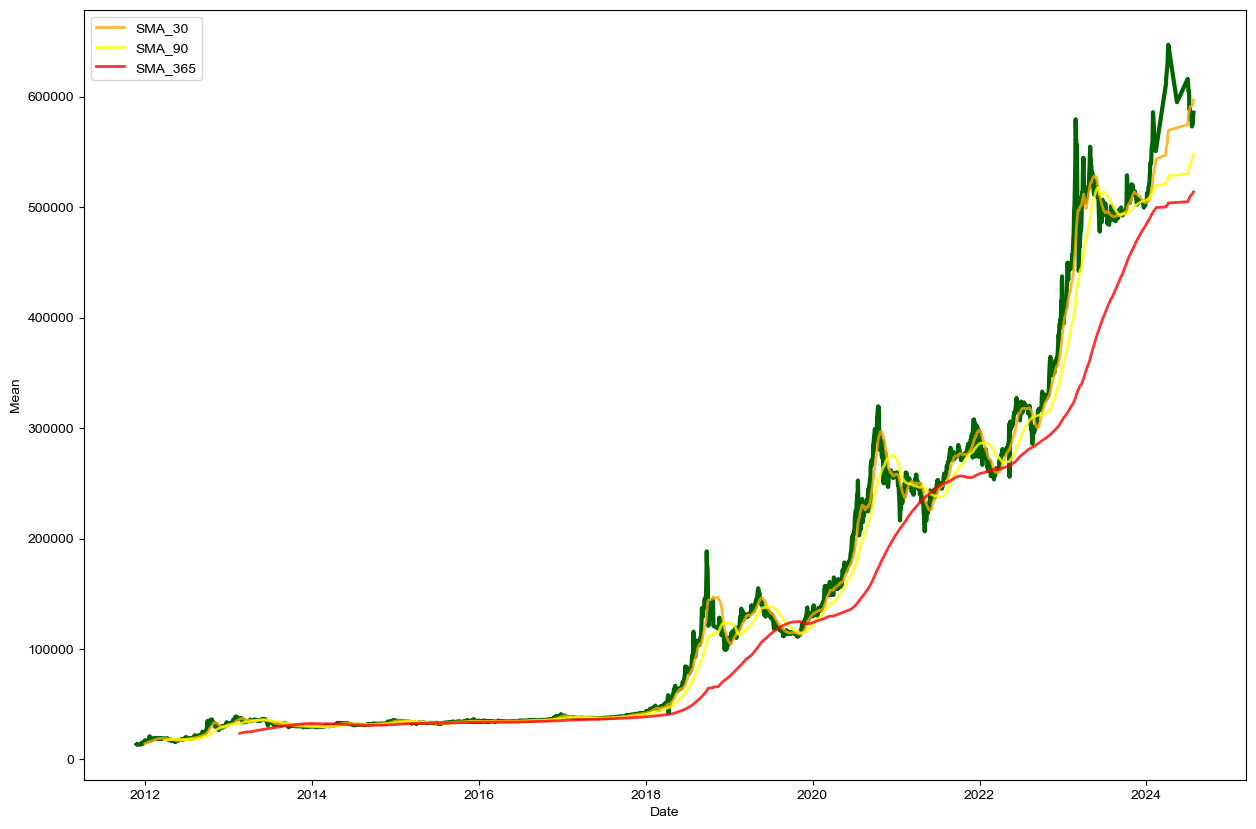

In [4]:
fig = plt.figure(figsize=(15,10))
sns.lineplot(x=df["Date"],y=df["Mean"],color="darkgreen",linewidth = 3)
df['SMA_30'] = df['Mean'].rolling(window=30).mean()
df['SMA_90'] = df['Mean'].rolling(window=90).mean()
df['SMA_365'] = df['Mean'].rolling(window=365).mean()
sns.lineplot(x=df["Date"],y=df["SMA_30"],linewidth = 2,color="orange",alpha=0.8,label="SMA_30",markers="-")
sns.lineplot(x=df["Date"],y=df["SMA_90"],linewidth = 2,color="yellow",alpha=0.8,label="SMA_90",markers="-")
sns.lineplot(x=df["Date"],y=df["SMA_365"],linewidth = 2,color="red",alpha=0.8,label="SMA_365",markers="-")

sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

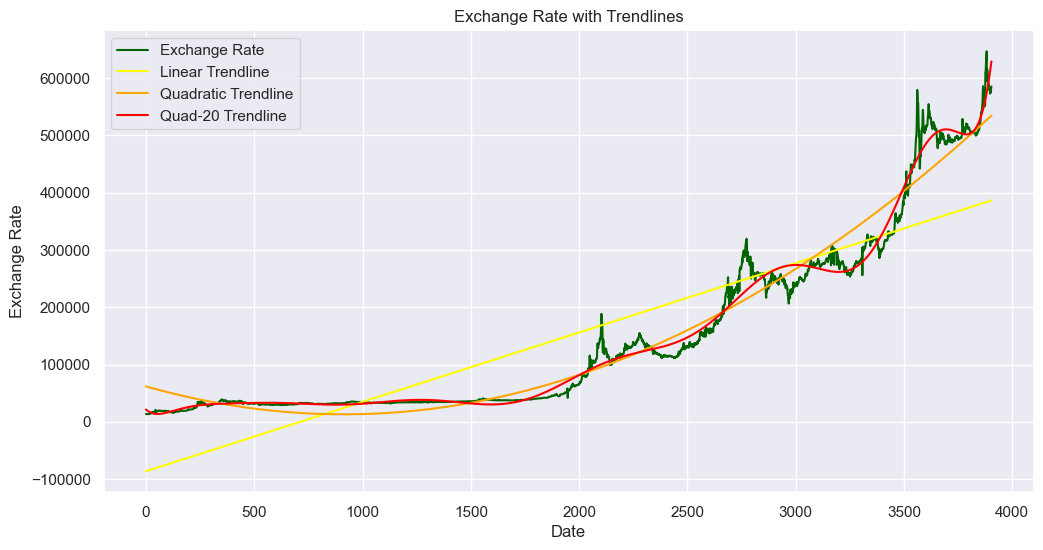

In [5]:
import matplotlib.dates as mdates
# Convert dates to numerical format
x = mdates.date2num(df.index)
y = df['Mean'].values

# Calculate linear trendline
linear_fit = np.polyfit(x, y, 1)  # Degree 1 for linear
linear_trendline = np.polyval(linear_fit, x)

# Calculate quadratic trendline
poly_fit = np.polyfit(x, y, 2)  # Degree 2 for quadratic
poly_trendline = np.polyval(poly_fit, x)

tri_fit = np.polyfit(x, y, 20)  # Degree 3 for quadratic
tri_trendline = np.polyval(tri_fit, x)

# Plot the original data and trendlines
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Mean'], label='Exchange Rate', color='darkgreen')
plt.plot(df.index, linear_trendline, label='Linear Trendline', color='yellow')
plt.plot(df.index, poly_trendline, label='Quadratic Trendline', color='orange')
plt.plot(df.index, tri_trendline, label='Quad-20 Trendline', color='red')

# Add titles and labels
plt.title('Exchange Rate with Trendlines')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
from sklearn.linear_model import Ridge as xgb

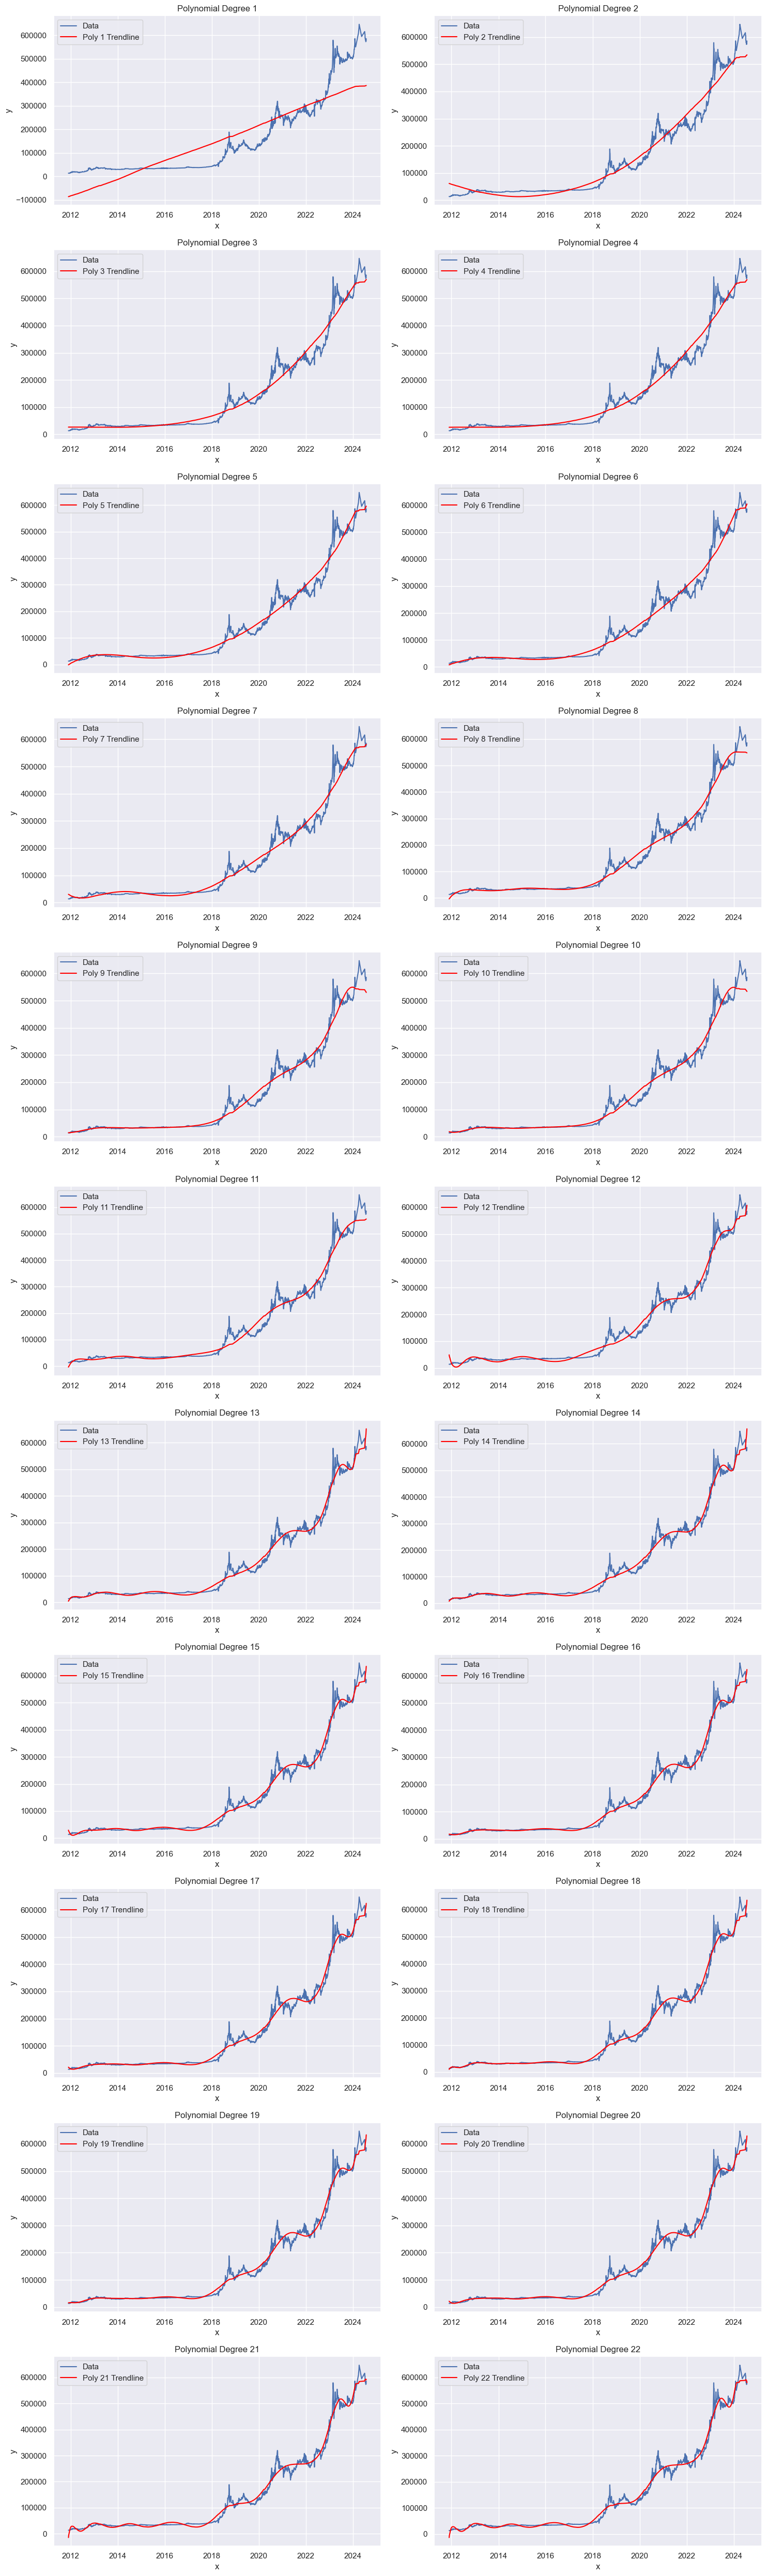

In [7]:
# Define the subplot grid
f, axes = plt.subplots(11, 2, figsize=(15, 50))  # Create a 15x3 grid
axes = axes.flatten()  # Flatten the 2D array to a 1D array for easy iteration

# Loop through each subplot
for i in range(1,23):
    # Fit a polynomial trendline of degree i
    fit = np.polyfit(x, y, i)
    trendline = np.polyval(fit, x)

    # Plot the data and trendline on the i-th subplot
    axes[i-1].plot(df['Date'], df['Mean'], '-', label='Data')
    axes[i-1].plot(df['Date'], trendline, label=f'Poly {i} Trendline', color='red')

    # Set the title and labels
    axes[i-1].set_title(f'Polynomial Degree {i}')
    axes[i-1].set_xlabel('x')
    axes[i-1].set_ylabel('y')
    axes[i-1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [8]:
xy_train = df.query('Date < "2018-05-01"')
xy_test = df.query('Date > "2018-05-01"')

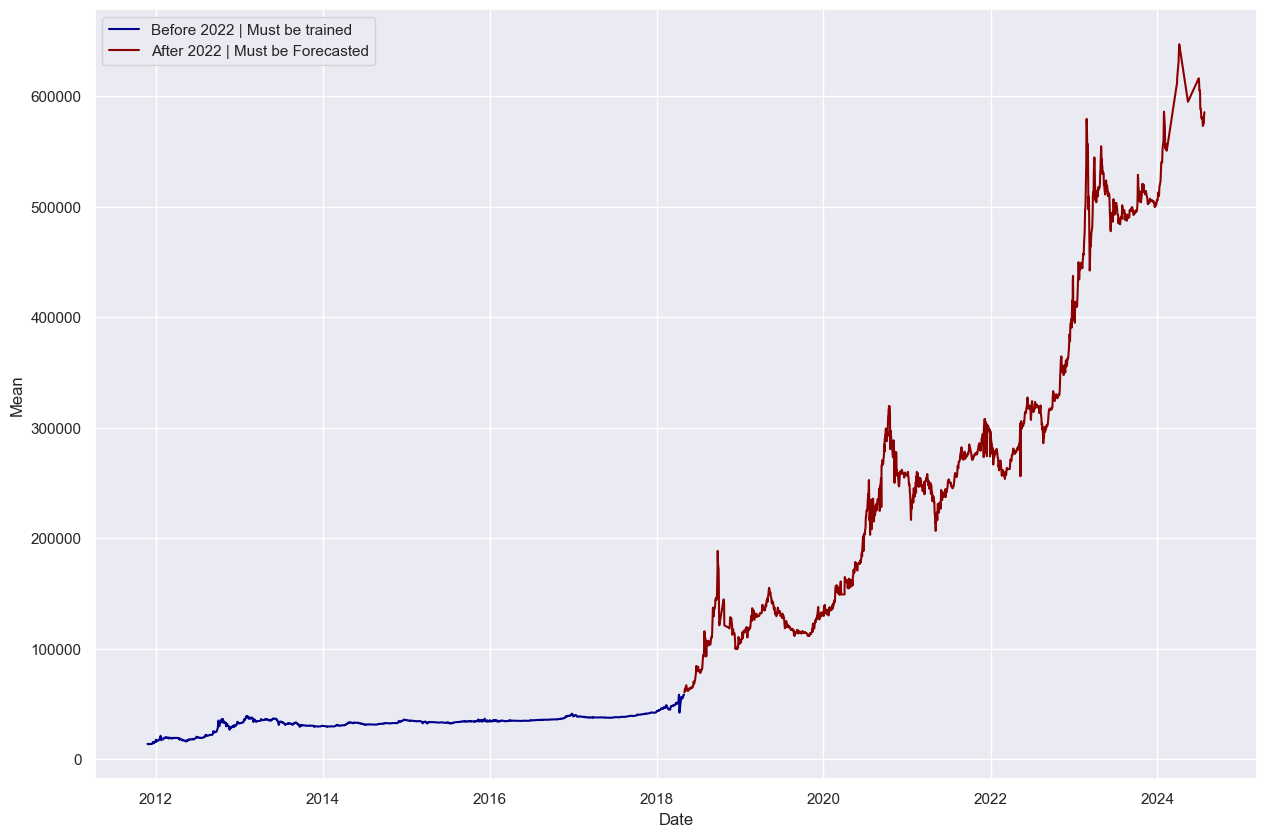

In [9]:
fig = plt.figure(figsize=(15,10))
sns.lineplot(x=xy_train["Date"],y=xy_train["Mean"],color="darkblue",label="Before 2022 | Must be trained")
sns.lineplot(x=xy_test["Date"],y=xy_test["Mean"],color="darkred",label="After 2022 | Must be Forecasted")
plt.legend(alignment="center")
plt.show()

In [10]:
m = Prophet(seasonality_mode="multiplicative",weekly_seasonality=True)
m.fit(xy_train[["ds","y"]])
xy_pred = m.predict(xy_train[["ds","y"]])[["ds","yhat"]]
print(r2_score(xy_train["y"],xy_pred["yhat"]))

05:54:38 - cmdstanpy - INFO - Chain [1] start processing
05:54:38 - cmdstanpy - INFO - Chain [1] done processing


0.9570318334162247


<Axes: xlabel='Date', ylabel='Mean'>

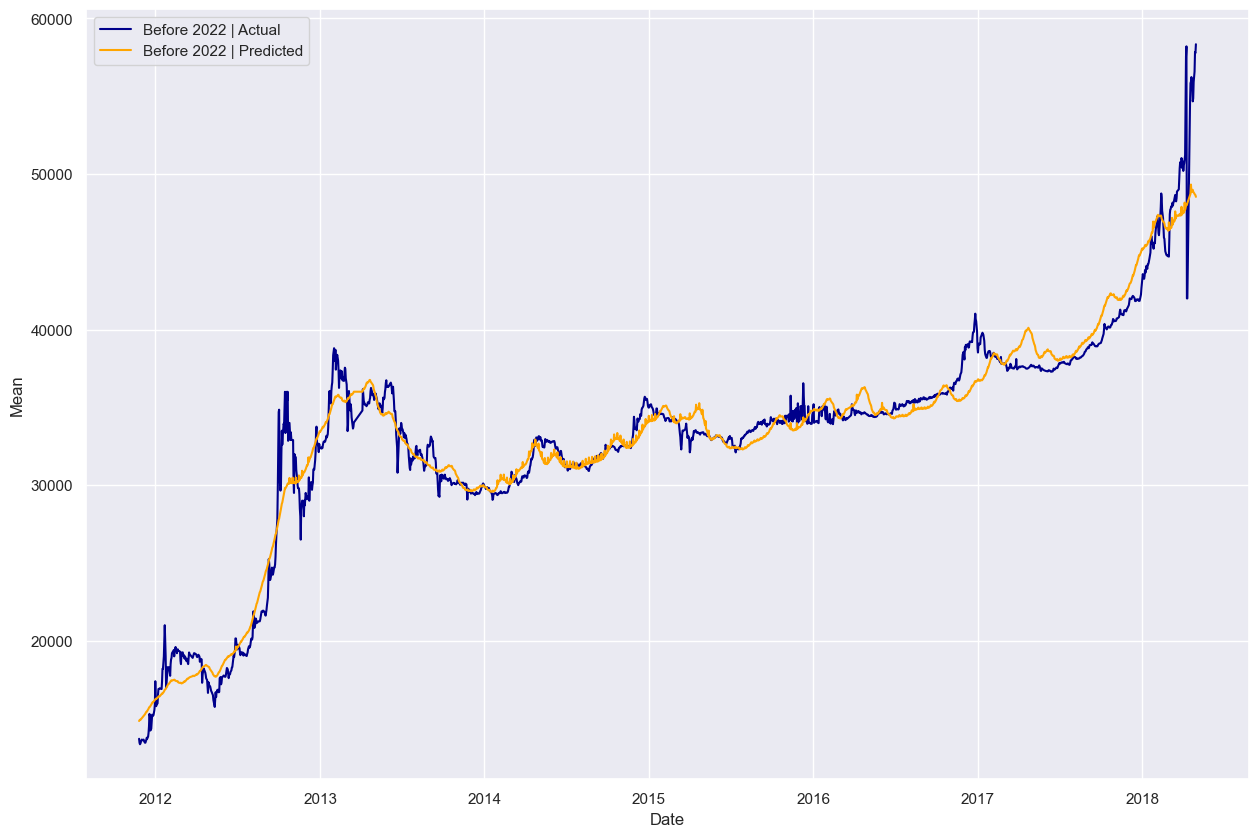

In [11]:
fig = plt.figure(figsize=(15,10))
sns.lineplot(x=xy_train["Date"],y=xy_train["Mean"],color="darkblue",label="Before 2022 | Actual")
sns.lineplot(x=xy_pred["ds"],y=xy_pred["yhat"],color="orange",label="Before 2022 | Predicted")

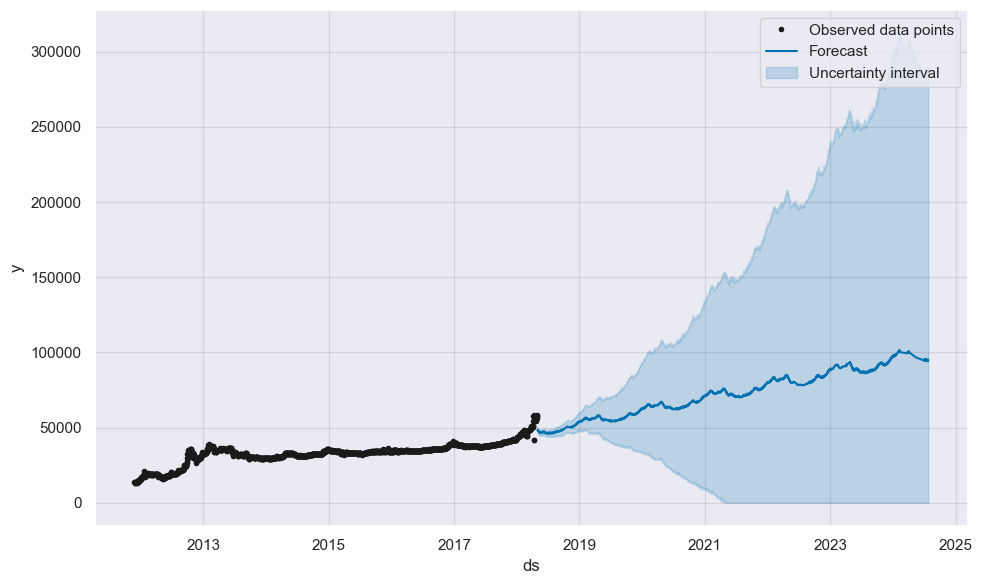

In [12]:
fcst = m.predict(xy_test)
un_fcst = fcst.copy()
for index, num in enumerate(un_fcst["yhat_lower"]):
    un_fcst["yhat_lower"][index] = np.maximum(num,0)
fig = m.plot(un_fcst,include_legend=True)

In [13]:
xy_forecast = pd.concat([fcst,xy_pred])[["ds","yhat"]]
xy_forecast

ds          yhat
0    2018-05-02  48171.583166
1    2018-05-03  48576.717355
2    2018-05-04  47905.155571
3    2018-05-05  47803.013335
4    2018-05-06  47723.194358
...         ...           ...
1957 2018-04-25  48815.514122
1958 2018-04-27  48707.987962
1959 2018-04-28  48668.000131
1960 2018-04-29  48637.183305
1961 2018-04-30  48528.155310

[3904 rows x 2 columns]

Text(2018-06-01 00:00:00, 600000, '"Barjam" suspended')

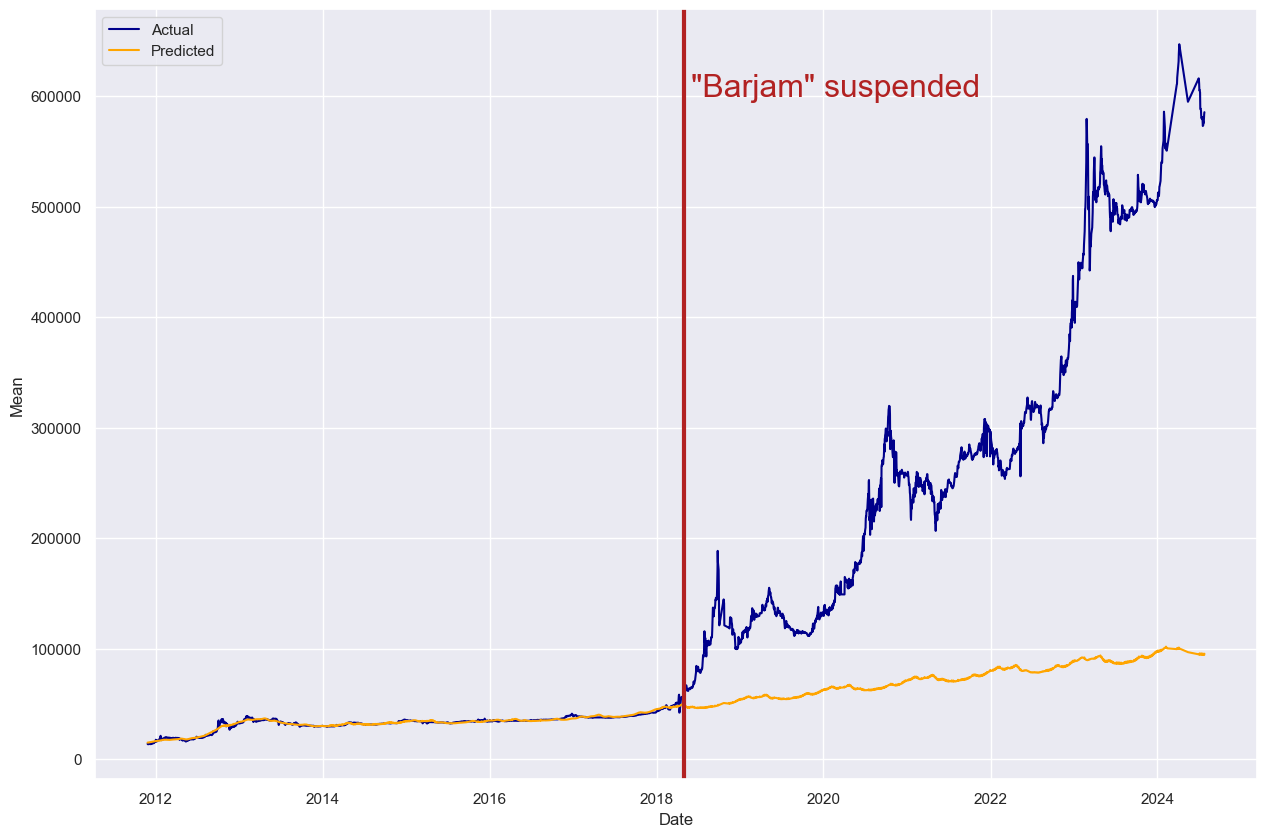

In [14]:
fig = plt.figure(figsize=(15,10))
sns.lineplot(x=df["Date"],y=df["Mean"],color="darkblue",label="Actual")
sns.lineplot(x=xy_forecast["ds"],y=xy_forecast["yhat"],color="orange",label="Predicted")
plt.axvline(dt.datetime(2018, 5, 1),linewidth=3,color="firebrick")
plt.text(x=dt.datetime(2018, 6, 1),y=600000,s='"Barjam" suspended',fontsize=23,color="firebrick")

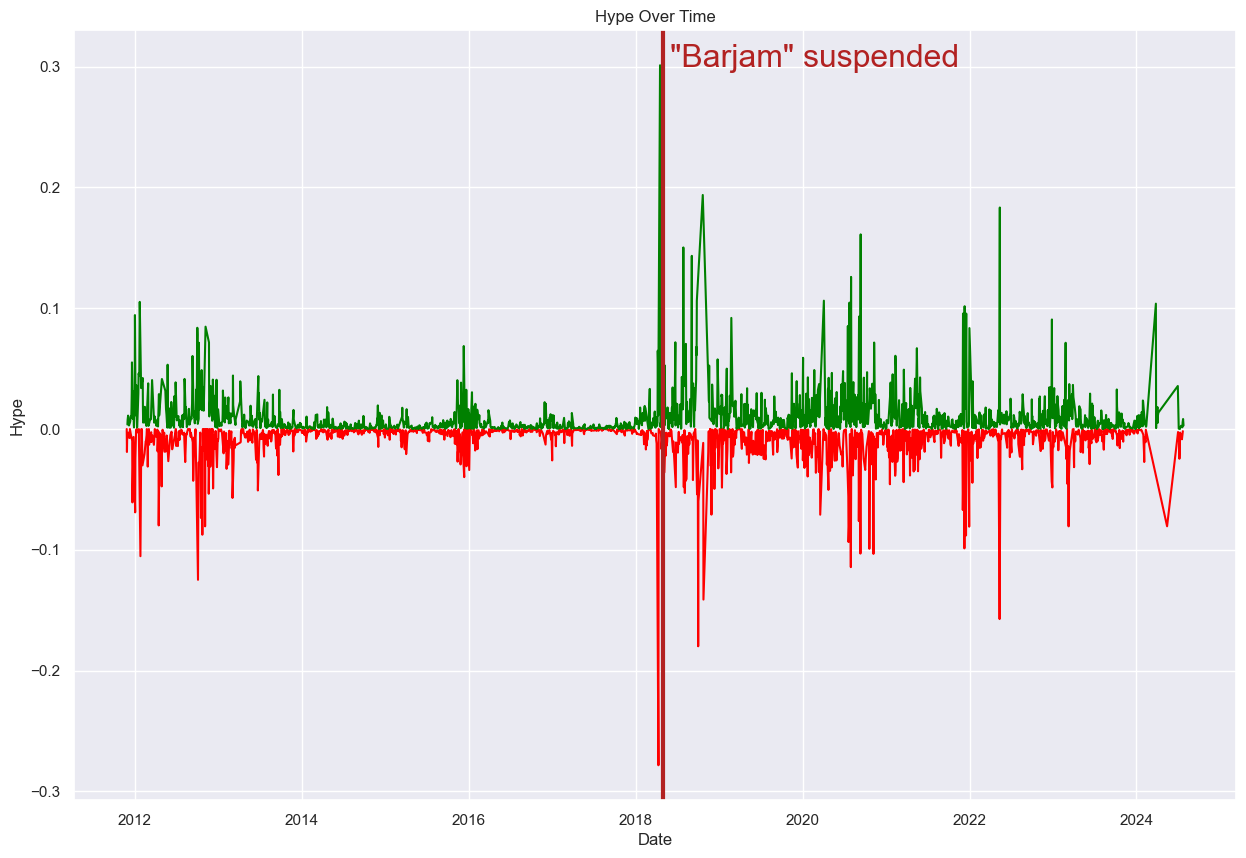

In [15]:
for index in range(len(df)):
    if index == 0:
        df["Hype"] = 0
    else:
        df["Hype"][index] = (df["Mean"][index] - df["Mean"][index-1])/df["Mean"][index-1]

# Create a column to determine positive and negative changes
df["positive"] = df["Hype"] > 0

# Plotting
fig = plt.figure(figsize=(15, 10))
sns.lineplot(x="Date", y="Hype", data=df, hue="positive", palette={True: 'green', False: 'red'}, legend=False)
plt.axvline(dt.datetime(2018, 5, 1), linewidth=3, color="firebrick")
plt.text(x=dt.datetime(2018, 6, 1), y=0.3, s='"Barjam" suspended', fontsize=23, color="firebrick")
plt.xlabel("Date")
plt.ylabel("Hype")
plt.title("Hype Over Time")
plt.show()

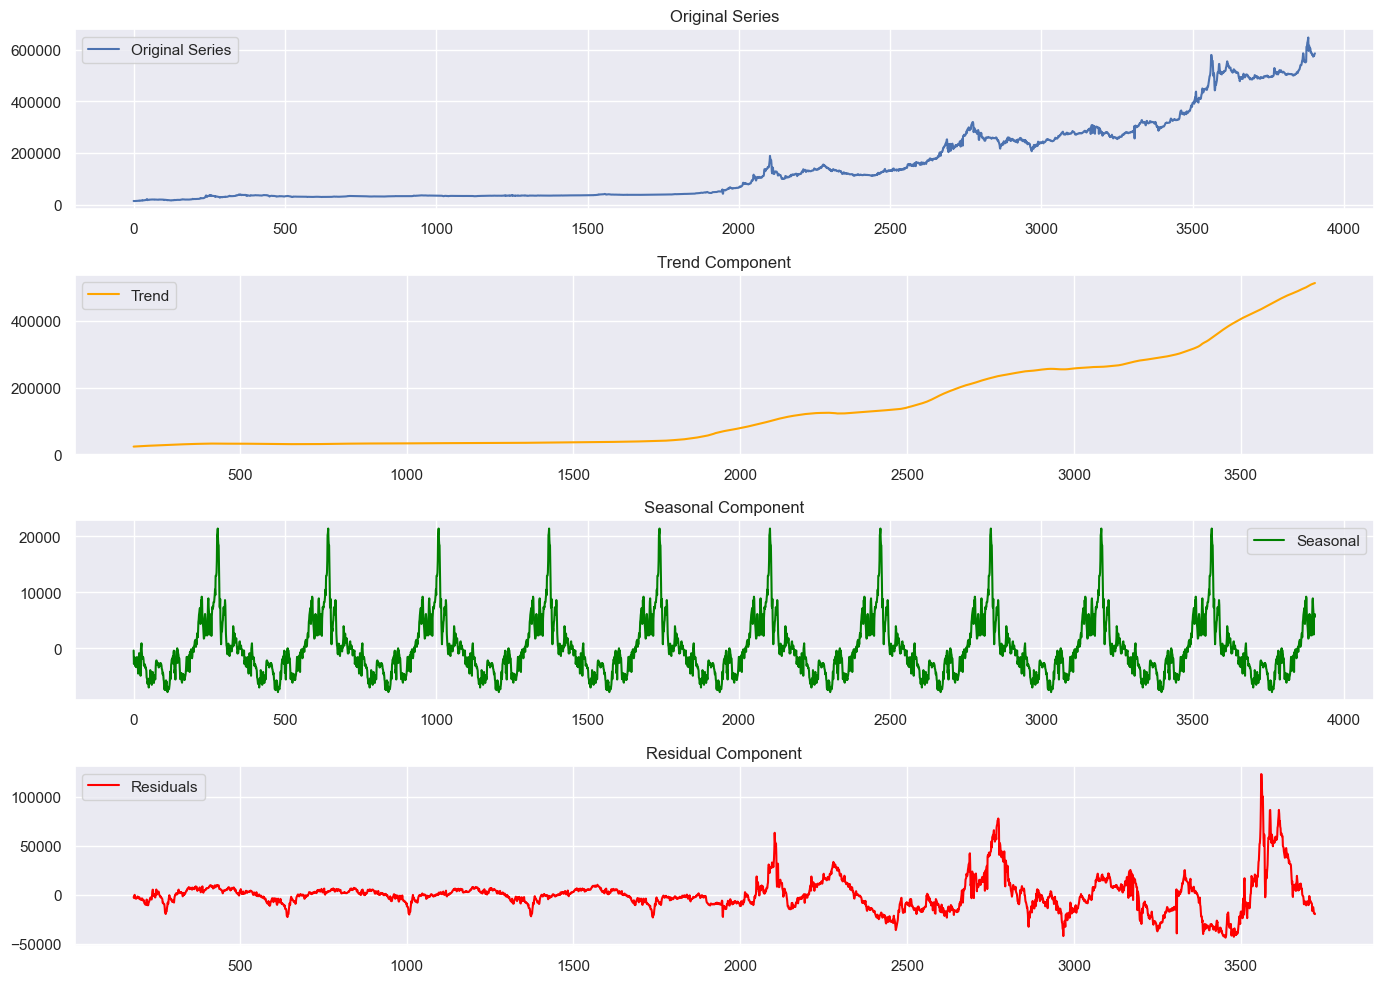

In [16]:

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Mean'], model='additive', period=365)  # Adjust period if needed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
plt.figure(figsize=(14, 10))

# Plot the original series
plt.subplot(4, 1, 1)
plt.plot(df.index, df['Mean'], label='Original Series')
plt.title('Original Series')
plt.legend(loc='best')

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(df.index, trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend(loc='best')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(df.index, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend(loc='best')

# Plot the residual component
plt.subplot(4, 1, 4)
plt.plot(df.index, residual, label='Residuals', color='red')
plt.title('Residual Component')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

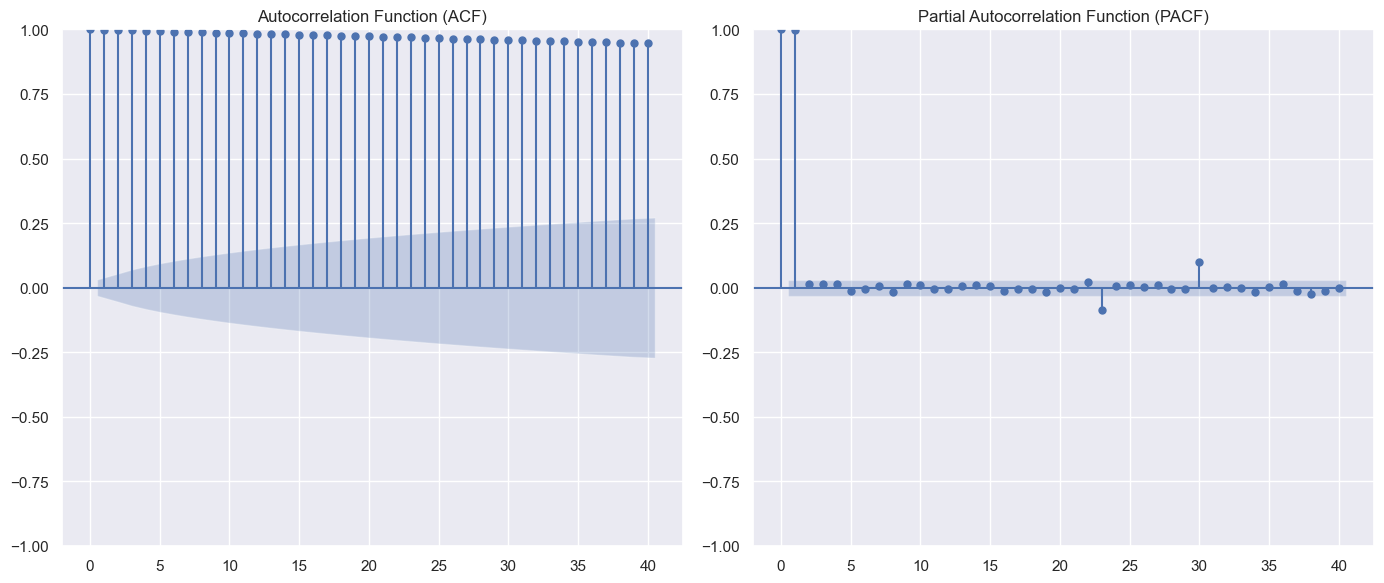

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the time series data
data = df['Mean']

# Plot ACF and PACF
plt.figure(figsize=(14, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(data, ax=plt.gca(), lags=40)  # Adjust lags as needed
plt.title('Autocorrelation Function (ACF)')

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(data, ax=plt.gca(), lags=40)  # Adjust lags as needed
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()